ABC-PyNetLogo
======

Here is an example on how to link pyABC Bayesian model with NotLogo.
First, ensure both pyabc and pyNetLogo packages are installed.

In [39]:
%matplotlib inline
import os
import tempfile

import scipy.stats as st
import math
import pyabc
import numpy as np
import pandas as pd

In [40]:
import pyNetLogo


#netlogo = pyNetLogo.NetLogoLink(gui=False)

# Define the setup for a simulation, including the names of the variables.
def simulation(res, lat, nucA, nucB, MTage):
    netlogo = pyNetLogo.NetLogoLink(gui=False, thd=False, netlogo_home='/home/dhardma2/NetLogo 6.1.1',netlogo_version=('6.1'))
    netlogo.load_model('*.nlogo')
    # Names of variables in NetLogo:
    netlogo.command('set {0} {1}'.format('resmax', res))
    netlogo.command('set {0} {1}'.format('lat-force', lat))
    netlogo.command('set {0} {1}'.format('nuc-forceA', nucA))
    netlogo.command('set {0} {1}'.format('nuc-forceB', nucB))
    netlogo.command('set {0} {1}'.format('Max-MT-age', MTage))

    netlogo.command('setup')
    
    
    #Run for 7200 ticks (plus residence time threshold) and return the number of nuclei at each time step
    #rm = round(netlogo.report('resmax'),0)
    mt = 0
    npt = 0
    sd_npt = 0
    n_dist = 0
    sd_n_dist = 0
    coeff_var = 0
    
    netlogo.command('repeat resmax + 7200 [go]')
    
    #Record median distance between nuclei and mean coefficient of variation    
    mt = netlogo.report('count myotubes')
    #npt =  netlogo.report('mean-nuc-per-tube')
    #sd_npt = netlogo.report('sd-nuc-per-tube')
    n_dist = netlogo.report('median-dist-nuc')
    #sd_n_dist = netlogo.report('sd-dist-nuc')            
    coeff_var = netlogo.report('mean-coeff-var') 
    #subtract observed from simulated here (this saves computational effort elsewhere)
    DiffMT=(mt-1030)/1000
    DiffND=(n_dist-48)/100
    DiffCV=(coeff_var-0.58)
    #create distance function here
    DistFunc= math.sqrt((DiffMT**2) + (DiffND**2) + (DiffCV**2))
    results=DistFunc
    netlogo.kill_workspace()
    return (results)

In [41]:
#Define simulation parameters
def model(parameters):
    res = parameters["resmax"]
    lat = parameters["lateral_force"]
    nucA=parameters["nuc_forceA"]
    nucB=parameters["nuc_forceB"]
    MTage=parameters["Max_MT_age"]
    data =simulation(res,lat,nucA,nucB,MTage)  
    return {"data": data}

In [42]:
#Set limits for distributions in pyABC. See pyABC documentation for more information.
parameter_priors = pyabc.Distribution(resmax=pyabc.RV("uniform", 50, 50), lateral_force=pyabc.RV("uniform", 0, 1), nuc_forceA=pyabc.RV("uniform", 0, 1),
                                      nuc_forceB=pyabc.RV("uniform", 0, 1), Max_MT_age=pyabc.RV("uniform", 0.5, 4.5))

In [43]:
#Set population starting and maximum sizes 
population =pyabc.populationstrategy.AdaptivePopulationSize(start_nr_particles=25, max_population_size = 100,nr_calibration_particles=10)

In [44]:
#Define distance function
def distance(x,y):
    return abs(x["data"] - y["data"])

In [45]:
#Run pyABC  
abc = pyabc.ABCSMC(model, parameter_priors, distance, population_size=2)#population)#, sampler = sampler)

INFO:Sampler:Parallelizing the sampling on 8 cores.


In [46]:
#Distance function calcualted internally in simulation
data_observed = 0
#define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "2pcSerumTest4.db"))
history = abc.new(db_path,{"data": data_observed})

INFO:History:Start <ABCSMC(id=7, start_time=2020-12-16 16:22:06.609362, end_time=None)>


In [47]:
print("ABC-SMC run ID:", history.id)

ABC-SMC run ID: 7


In [48]:
##### We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.3, max_nr_populations=3)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.933042056262732
INFO:ABC:t: 0, eps: 0.933042056262732.
INFO:ABC:Acceptance rate: 2 / 10 = 2.0000e-01, ESS=2.0000e+00.
INFO:ABC:t: 1, eps: 0.8914773998853274.
INFO:ABC:Acceptance rate: 2 / 17 = 1.1765e-01, ESS=1.9995e+00.
INFO:ABC:t: 2, eps: 0.8580896549720101.
INFO:ABC:Acceptance rate: 2 / 18 = 1.1111e-01, ESS=1.9972e+00.
INFO:History:Done <ABCSMC(id=7, start_time=2020-12-16 16:22:06.609362, end_time=2020-12-16 16:27:25.157942)>


In [1]:
netlogo.kill_workspace()

NameError: name 'netlogo' is not defined

Note that the history object is also always accessible from the abcsmc object:

In [2]:
history is abc.history

NameError: name 'history' is not defined

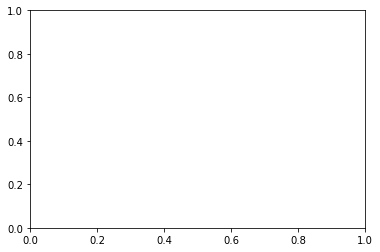

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=80, xmax=90,
        x="resmax", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

The `pyabc.storage.History>` object can, for example,
be queried for the posterior probabilities in the populations:

And now, let's visualize the results:

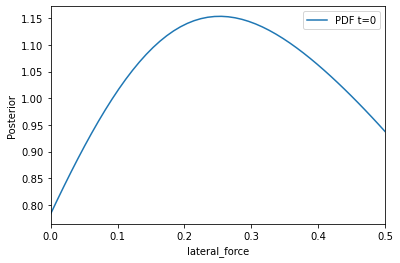

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=0.5,
        x="lateral_force", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

So model 1 is the more probable one. Which is expected as it was centered at 1 and the observed data was also 1, whereas model 0 was centered at 0, which is farther away from the observed data. 

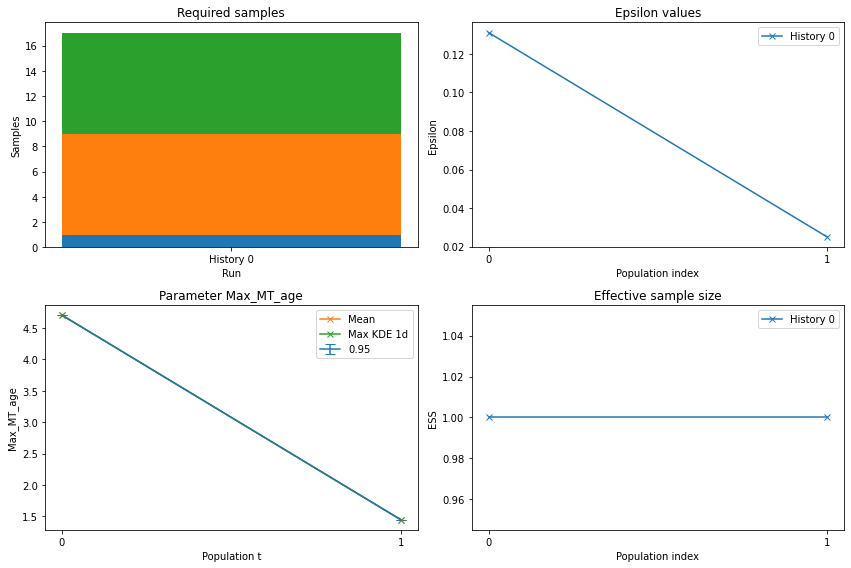

In [30]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
pyabc.visualization.plot_credible_intervals(
    history, show_mean=True, show_kde_max_1d=True,
    #refval={'mean': 2.5}, 
    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

/home/dhardma2/.local/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)
/home/dhardma2/.local/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)
/home/dhardma2/.local/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='f

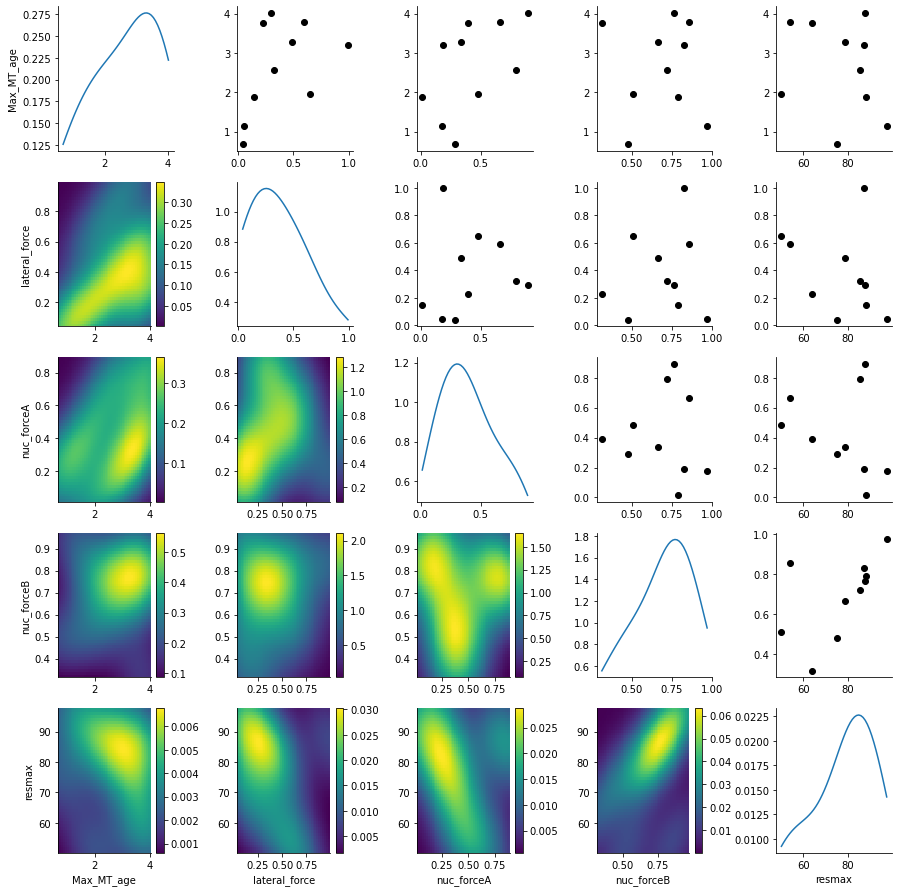

In [50]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

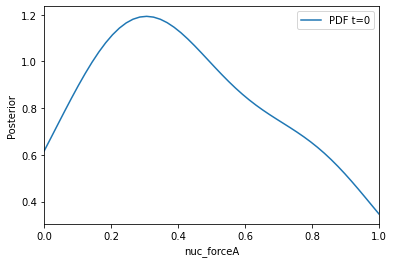

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=1,
        x="nuc_forceA", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

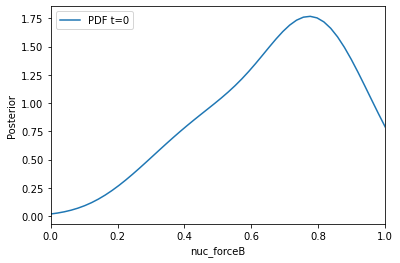

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=1,
        x="nuc_forceB", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();